# 카메라 스티커앱 만들기

## 사진 준비하기

In [1]:
# 모듈 불러오기

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print("완료")

완료


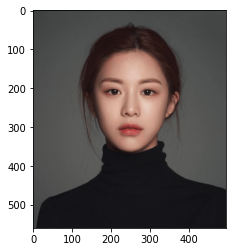

In [2]:
# 준비한 이미지 불러오기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/goyounjung.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지 따로 저장

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 색상 RGB로 전환하기
plt.imshow(img_rgb)
plt.show()

---

## 얼굴 검출 face detection

In [3]:
# dlib 이용한 hog detector 선언

detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# dlib detector 는 dlib.rectangles 타입의 객체를 반환
# image pyramid : 이미지 unsampling으로 크기를 키우는 것
# -> 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능

print(dlib_rects)

rectangles[[(142, 142) (365, 365)]]


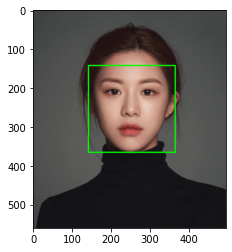

In [4]:
# dlib.rectangles 는 dlib.rectangle 객체의 배열 형태
# dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # bounding box가 포함된 사진 저장

plt.imshow(img_show_rgb)
plt.show()

---

## 얼굴 랜드마크 face landmark

In [5]:
# landmark 모델 불러오기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

print("완료")

완료


In [6]:
# 얼굴 영역 박스마다 face landmark를 찾아내기

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아서
    # dlib.full_object_detection 를 반환
    
    # face landmark 좌표를 저장해두기
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    # points는 dlib.full_object_detection의 객체이기에 parts() 함수로 개별적인 위치인 (x,y)형태로 접근할 수 있도록 변환
    # 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됨
    # 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됨

print(len(list_landmarks[0]))

68


복잡하니깐 추가 메모

map함수 이용 : (a,b) -> points.part()에서 x와 y를 추출해 list_points = [(x1, y1), (x2, y2), ... , (x68, y68)] 만들고

append를 이용 : list_landmarks라는 리스트에 추가하면 list_landmarks = [ [ (x1, y1), (x2, y2), ... , (x68, y68) ] ]

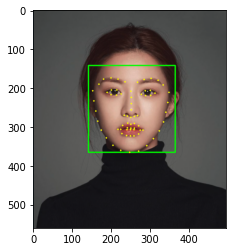

In [7]:
# 랜드마크를 사진에 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---

## 스티커 적용 위치 확인하기

In [8]:
# 코끝 좌표와 이미지 사이즈 설정
# (x,y) : 코끝 좌표
# (w,h) : 스티커 크기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("코끝의 위치 :", landmark[30]) # 코끝의 index는 30
    x = landmark[30][0] # 스티커 중앙의 x좌표값
    y = landmark[30][1] # 스티커 중앙의 y좌표값
    w = dlib_rect.width() # 수염 스티커 너비 설정 = bounding box 너비
    h = dlib_rect.width() # 수염 스티커 높이 설정 = bounding box 높이
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

코끝의 위치 : (252, 256)
(x,y) : (252,256)
(w,h) : (224,224)


(224, 224, 3)


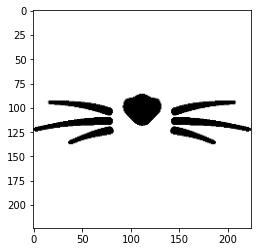

In [9]:
# 스티커 불러와서 크기 resize

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 불러오기
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 크기 조정하기
print (img_sticker.shape)
plt.imshow(img_sticker)

---

## 스티커 적용하기

In [10]:
# 스티커 이미지의 좌표 조정 필요
# 스티커 이미지가 들어갈 영역은 top-left 좌표이기 때문에 코끝의 좌표에서 옮겨줘야 함

refined_x = int(x - w//2) # 제일 왼쪽 상단
refined_y = int(y - h//2) # 제일 위쪽 상단
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (140,144)


In [11]:
# 원본 이미지에 스티커 적용

# img_show[from:to] 형식
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 스티커 이미지에서 사용할 부분은 검은색이 있는 부분만 사용
# np.where를 통해 img_sticker가 255인 부분은 sticker_area를 사용
# 255이 아닌 부분은 img_sticker 사용, img_show에 다시 적용

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

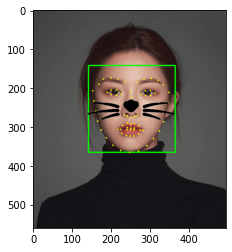

In [12]:
# 결과 이미지 출력

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

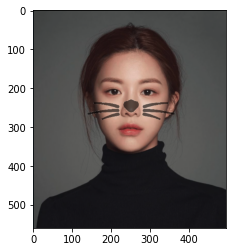

In [13]:
# bounding box와 landmark 제거하고 최종결과만 출력
# 출력용 이미지가 아닌 원본으로 다시 적용
# cv2.addWeighted 사용해서 스티커에 40% 투명도 조절

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, cv2.addWeighted(img_sticker, 0.6, sticker_area, 0.4,0)).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---

## 다양한 이미지에서 얼굴 검출해보기

### 1. 어두운 이미지

rectangles[[(187, 80) (294, 187)]]


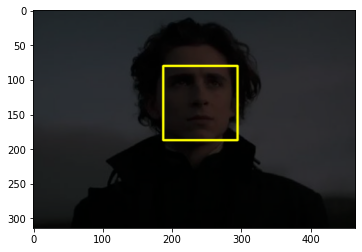

In [14]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/timotheechalamet.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,255), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

사진이 엄청 어둡지만 얼굴이 배경보다 아주 미세하게 밝을 때는 얼굴 detect이 가능한 것 같다.

rectangles[]


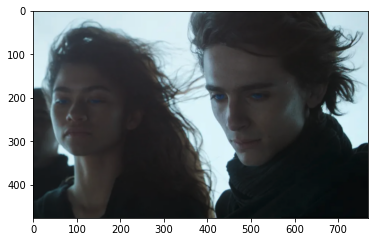

In [15]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/timozendaya.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

배경보다 얼굴이 많이 어두울 때는 얼굴 detect를 잘 못하는 것 같다.

rectangles[[(15, 139) (201, 325)]]


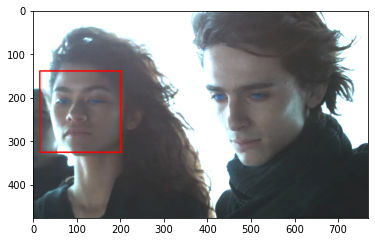

In [16]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/timozendaya_bright.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,0,255), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

똑같은 사진을 좀더 밝게 했을 때, 조금 더 정면에 가까운 왼쪽의 젠다야의 얼굴만 인식했다. 오른쪽의 티모시샬라메는 얼굴이 기울어져있고, 왼쪽 얼굴 윤곽이 명확하지 않아서인지 인식하지 못했다.

### 2. 다양한 얼굴 각도에 대한 인식

rectangles[[(366, 72) (417, 124)], [(233, 38) (285, 90)]]


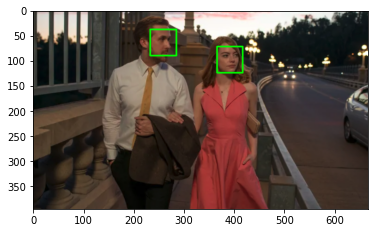

In [17]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/lalaland.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

옆을 보고 있는 얼굴들에 대한 인식은 잘되는듯하다.

rectangles[]


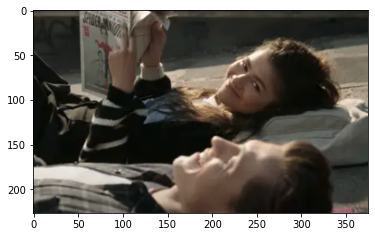

In [18]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/petermj.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,2)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

누워있어서 얼굴의 각도가 완전히 틀어졌거나, 얼굴이 흐릿한 경우는 인식을 못하는 것 같다.

### 3. 멀리서 찍은 여러 얼굴 인식하기

rectangles[[(389, 218) (407, 236)], [(223, 281) (244, 303)], [(422, 286) (444, 308)], [(317, 214) (335, 232)], [(708, 224) (729, 245)], [(484, 279) (506, 300)], [(247, 220) (265, 238)], [(551, 180) (569, 198)], [(113, 228) (131, 246)], [(287, 280) (305, 298)], [(355, 180) (373, 198)], [(41, 218) (59, 236)], [(485, 178) (503, 196)], [(617, 288) (635, 306)], [(687, 290) (705, 308)], [(583, 226) (605, 248)], [(86, 291) (108, 312)], [(350, 286) (372, 308)], [(645, 234) (663, 252)], [(291, 170) (309, 188)], [(515, 214) (533, 232)], [(144, 183) (165, 204)], [(555, 286) (573, 304)], [(613, 176) (631, 194)], [(159, 292) (177, 310)], [(419, 174) (437, 192)], [(455, 216) (473, 234)], [(177, 216) (195, 234)]]


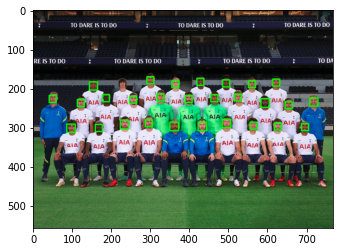

In [19]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hotspur.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,2)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

멀리있는 작은 얼굴들을 인식할 때에, 처음에 image pyramid 값을 1로 했을 때는 인식을 못했는데, 2로 올려서 다시 해보니깐 한명 빼고 다 인식이 가능했다.

### 4. 애니메이션 얼굴도 인식 가능할까?

rectangles[[(590, 164) (642, 216)]]


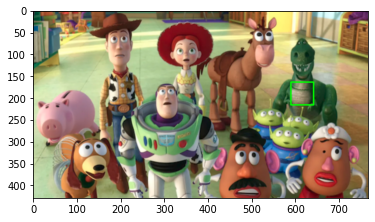

In [20]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/toystory.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

.... 눈코입이 붙어있다고 다 인식 가능한 것은 아니었다.

---

## 얼굴 각도에 따라 스티커 각도 변화시켜서 적용하기

rectangles[[(301, 199) (532, 430)]]


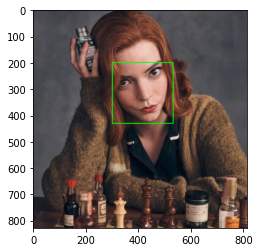

In [21]:
# 이미지 불러온 뒤 얼굴 검출해서 bounding box 추출

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/anya.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,2)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

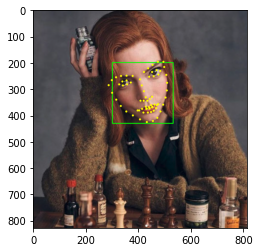

In [22]:
# landmark 모델 불러온 뒤 이미지에 출력하기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 4, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [23]:
# 스티커 적용위치 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("코끝의 위치 :", landmark[30])
    x = landmark[30][0] 
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

코끝의 위치 : (428, 331)
(x,y) : (428,331)
(w,h) : (232,232)


(232, 232, 3)


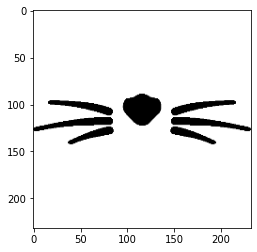

In [24]:
# 스티커 불러와서 크기 resize

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

In [25]:
# 스티커 회전 각도 구하기

import math

# 코끝의 좌표와 미간의 좌표 사이의 거리를 이용하여 tangent 값 도출
tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])

#numpy의 역탄젠트 함수, math의 pi 함수 이용하여 회전각도 도출
theta = np.arctan(tan_theta)
rotate_angle = theta*180/math.pi
print(rotate_angle)

17.927919762007235


(232, 232, 3)


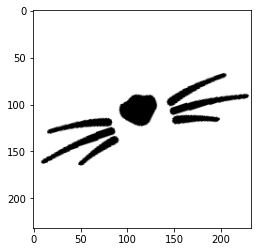

In [26]:
# 스티커 회전 함수 만들어서 회전시키기
# cv2.getRotationMatrix2D(회전변환행렬 생성)와 cv2.warpAffine(이동변환) 클래스 사용

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2) # 중심점 : 튜플 형태로 사용하며 회전의 기준점을 설정
  matrix = cv2.getRotationMatrix2D(image_center, angle, 1) # 중심점과 각도를 변형하는 행렬을 선언 (중심점, 각도, 확대비율)
  result = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
                         # flag는 보간법, borderValue는 이동변환을 했을 때 생기는 빈공간을 어떤 색깔로 채울 것인지
  return result

img_rotated = rotate_image(img_sticker,rotate_angle)
print(img_rotated.shape)
plt.imshow(img_rotated)
plt.show()

(x,y) : (312,215)


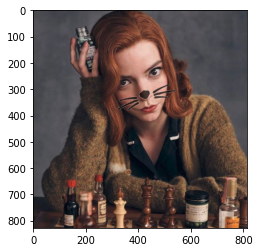

In [27]:
# 스티커 이미지의 좌표 조정
# 회전된 스티커 투명도 30% 부여해서 적용

refined_x = int(x - w//2) 
refined_y = int(y - h//2)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_rotated==255,sticker_area, cv2.addWeighted(img_rotated, 0.7, sticker_area, 0.3,0)).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---

## 회고

- 이번 프로젝트는 일단 굉장히 재밌었다. 물론 코드들을 하나하나 해석하고 적용하는 것이 조금 어려웠지만, 하나하나 차근차근히 이해해 가다보니 왜 이렇게 동작하고 실행되는지 깨달을 수 있었다.

- 이미지만 불러오면 dlib의 hog detector를 통해 얼굴 영역을 인식하고, 랜드마크 모델을 통해 얼굴의 이목구비가 저절로 인식이 되는 과정이 편했지만, 그 모델들이 어떤 방식으로 작동하는지에 대해서는 나중에 공부할 기회가 있을까 싶다. 궁금하긴 하지만 아직 너무 어려운 부분일 것 같기 때문에, 일단은 불러와서 쓰는데에 익숙해져야 할 것 같다.

- 스티커를 적용하는데에 있어서는, 이미지 좌표에 대해 좀더 공부하고 익숙해져야 할 것 같다. 스티커를 적용할 위치를 좌표 상에서 계산하는 것도 그렇고, resize 하는 과정에서 계산하는 방식에 대해서도 머리를 써야한다.

- 얼굴 영역을 저절로 인식하는 것이 신기해서 다양한 각도와 이미지의 밝기 등의 여러 변수가 생겼을 때도 잘 인식하나 확인해봤는데, 결과가 들쭉날쭉하지만 어느 정도 기대대로 잘 인식되는 것 같다. 생각해보면 우리가 실제로 쓰는 카메라 스티커 어플도 너무 어둡거나 누워있으면 인식을 잘 못했던 것 같다.

- 기울어진 얼굴의 각도에 맞춰서 스티커도 회전시켜 적용하는 방법을 고민해보다가, 이것저것 구글링하고 다른 사람들의 깃허브도 들어가서 공부해보면서 평면상에서 간단히 회전시키는 방법을 찾았다. 회전각도를 계산하는 것도 그렇고 회전 함수를 짜는 것도 아직 미숙해서 많이 차용했지만, 의미를 분석해보고 함수 하나하나 찾아가면서 공부해보니 계속 적용시키다 보면 익숙하게 쓸 수 있을 것 같았다. 다음에는 입체적으로 회전시키는 방법도 찾아보고 분석해서 공부해봐야겠다.